In [110]:
import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [111]:
import flappy_bird_gymnasium
import gymnasium as gym

# env = gym.make("FlappyBird-v0", render_mode="human", use_lidar=True)
env = gym.make("FlappyBird-v0")
obs, info = env.reset()

In [112]:
# env.reset()
# state,_ = env.reset()
# done = False
# while not done:
#     action = int(np.random.choice([0,1]))
#     next_state, reward, done, truncated, _ = env.step(action)
#     print(action,reward)

In [113]:
state_size = 180
action_size = 2

In [114]:
class DQN(nn.Module):
    
    def __init__(self,state_size,action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size,150)
        self.fc2 = nn.Linear(150,150)
        self.fc3 = nn.Linear(150,action_size)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [115]:
dqn = DQN(state_size,action_size)

In [116]:
x = torch.ones((1,180))

In [117]:
x

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [118]:
dqn(x)

tensor([[-0.0871,  0.1561]], grad_fn=<AddmmBackward0>)

In [119]:
np.random.random()

0.22830685384208693

In [120]:
def convert(state):
    state_tensor = torch.FloatTensor(state)
    return state_tensor

In [121]:
class Agent:
    
    def __init__(self):
        
        self.eplison = 1.0
        self.eplison_min = 0.01
        self.eplison_decay = 0.995
        self.gamma = 0.95
        
        self.model = DQN(state_size,action_size)
        self.crition = nn.MSELoss()
        self.optimizer = optim.AdamW(self.model.parameters(),lr=0.001)
        
        self.memory = deque(maxlen=500)
    
    
    def take_action(self,state,explore=True):
        if explore:
            if np.random.random() < self.eplison:
                action = np.random.randint(action_size)
            else:
                with torch.no_grad():
                    action_values = self.model(state)
                    action = torch.argmax(action_values).item()
            return action
        else:
            with torch.no_grad():
                action_values = self.model(state)
                action = torch.argmax(action_values).item()
            return action
                

    def remember(self,state,action,reward,next_state,done):
        self.memory.append((state,action,reward,next_state,done))
    
    
    def update(self):
        batch_size = 32
        arr = random.sample(self.memory,batch_size)
        loss = 0
        for state,action,reward,next_state,done in arr:
            
            state_tensor = convert(state)
            action_values = self.model(state_tensor)
            
            next_state_tensor = convert(next_state)
            target_f = reward
            if not done:
                with torch.no_grad():
                    target_values = self.model(next_state_tensor)
                    target_f = reward + self.gamma * torch.max(target_values)
                    target_f = target_f.item()
#             tag = action_values.clone().detach()
#             tag[action] = target_f
            loss += (action_values[action]-target_f)**2
        loss /= len(arr)
#         loss = self.crition(action_values,tag)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.eplison > self.eplison_min:
            self.eplison *= self.eplison_decay

In [122]:
agent = Agent()

In [123]:
agent.eplison = 0
agent.memory = deque(maxlen=2000)

In [124]:
for e in range(5000):
    
    state,_ = env.reset()
    count = 0
    rw = 0
    for x in range(6000):
        state_tensor = convert(state)
        action = agent.take_action(state_tensor)
        next_state,reward,done,_,_ = env.step(action)
        agent.remember(state,action,reward,next_state,done)
        state = next_state
        count += 1
        rw += reward
        if done:
            break
        
        if len(agent.memory) > 32:
            agent.update()
        

    if e % 10 == 0:  # 修正条件
        print(f"Episode: {e}/{500}, Reward: {rw}, Epsilon: {agent.eplison:.4f}")


Episode: 0/500, Reward: 0.8000000000000012, Epsilon: 0.0000
Episode: 10/500, Reward: 2.3999999999999986, Epsilon: 0.0000
Episode: 20/500, Reward: 1.799999999999999, Epsilon: 0.0000
Episode: 30/500, Reward: 2.0999999999999996, Epsilon: 0.0000
Episode: 40/500, Reward: -7.499999999999998, Epsilon: 0.0000
Episode: 50/500, Reward: 2.6999999999999993, Epsilon: 0.0000
Episode: 60/500, Reward: -0.8999999999999986, Epsilon: 0.0000
Episode: 70/500, Reward: 2.8999999999999986, Epsilon: 0.0000
Episode: 80/500, Reward: -9.299999999999999, Epsilon: 0.0000
Episode: 90/500, Reward: 2.299999999999999, Epsilon: 0.0000
Episode: 100/500, Reward: -0.8999999999999986, Epsilon: 0.0000
Episode: 110/500, Reward: 2.0000000000000018, Epsilon: 0.0000
Episode: 120/500, Reward: 1.700000000000002, Epsilon: 0.0000
Episode: 130/500, Reward: 2.1999999999999975, Epsilon: 0.0000
Episode: 140/500, Reward: 0.9000000000000004, Epsilon: 0.0000
Episode: 150/500, Reward: -2.5999999999999988, Epsilon: 0.0000
Episode: 160/500, R

KeyboardInterrupt: 

In [125]:
def test_agent(agent, episodes=10, render=True):
    env = gym.make('FlappyBird-v0', render_mode='human' if render else None)

    for e in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            if render:
                env.render()
            state = convert(state)
            action = agent.take_action(state, explore=False)  # 测试时不探索
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            total_reward += reward
            
            if done:
                print(f"Test episode: {e+1}/{episodes}, score: {total_reward}")
                break

In [126]:
test_agent(agent)

Test episode: 1/10, score: 4.599999999999978
Test episode: 2/10, score: 21.000000000000195
Test episode: 3/10, score: -0.7000000000000031
Test episode: 4/10, score: 1.9999999999999911
Test episode: 5/10, score: 6.099999999999948
Test episode: 6/10, score: 24.70000000000022
Test episode: 7/10, score: 11.499999999999943
Test episode: 8/10, score: 7.099999999999964
Test episode: 9/10, score: 0.19999999999999218


KeyboardInterrupt: 

Using device: cpu
State size: 180, Action size: 2


Training:   0%|                                     | 0/500 [00:00<?, ?it/s]/Users/liuchu/opt/anaconda3/envs/mem0/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Users/liuchu/opt/anaconda3/envs/mem0/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
Training:   2%|▋                           | 12/500 [00:00<00:43, 11.27it/s]

Episode: 10/500, Reward: -0.80, Avg Reward: -2.38, Epsilon: 0.1080


Training:   4%|█▏                          | 21/500 [00:02<01:10,  6.75it/s]

Episode: 20/500, Reward: 1.40, Avg Reward: -1.19, Epsilon: 0.0100


Training:   6%|█▋                          | 31/500 [00:03<01:20,  5.80it/s]

Episode: 30/500, Reward: 1.10, Avg Reward: 0.16, Epsilon: 0.0100


Training:   8%|██▎                         | 41/500 [00:05<01:01,  7.44it/s]

Episode: 40/500, Reward: 0.10, Avg Reward: 0.29, Epsilon: 0.0100


Training:  10%|██▊                         | 51/500 [00:06<01:06,  6.73it/s]

Episode: 50/500, Reward: -0.60, Avg Reward: 0.53, Epsilon: 0.0100


Training:  12%|███▎                        | 60/500 [00:07<01:01,  7.21it/s]

Episode: 60/500, Reward: 0.80, Avg Reward: 0.64, Epsilon: 0.0100


Training:  14%|███▉                        | 70/500 [00:09<01:01,  7.03it/s]

Episode: 70/500, Reward: 1.60, Avg Reward: 0.73, Epsilon: 0.0100


Training:  16%|████▌                       | 81/500 [00:11<00:56,  7.47it/s]

Episode: 80/500, Reward: 1.80, Avg Reward: 0.90, Epsilon: 0.0100


Training:  18%|█████                       | 91/500 [00:12<00:48,  8.42it/s]

Episode: 90/500, Reward: 3.60, Avg Reward: 0.99, Epsilon: 0.0100


Training:  20%|█████▍                     | 100/500 [00:15<02:59,  2.23it/s]

Episode: 100/500, Reward: 3.30, Avg Reward: 1.15, Epsilon: 0.0100


Training:  22%|██████                     | 112/500 [00:16<00:52,  7.46it/s]

Episode: 110/500, Reward: 4.30, Avg Reward: 1.68, Epsilon: 0.0100


Training:  24%|██████▌                    | 121/500 [00:17<00:58,  6.45it/s]

Episode: 120/500, Reward: 0.90, Avg Reward: 1.91, Epsilon: 0.0100


Training:  26%|███████                    | 131/500 [00:19<01:06,  5.51it/s]

Episode: 130/500, Reward: 5.50, Avg Reward: 1.90, Epsilon: 0.0100


Training:  28%|███████▌                   | 140/500 [00:21<01:04,  5.58it/s]

Episode: 140/500, Reward: 4.50, Avg Reward: 2.32, Epsilon: 0.0100


Training:  30%|████████▏                  | 151/500 [00:22<00:44,  7.88it/s]

Episode: 150/500, Reward: 2.40, Avg Reward: 2.56, Epsilon: 0.0100


Training:  32%|████████▋                  | 160/500 [00:24<01:06,  5.10it/s]

Episode: 160/500, Reward: 4.80, Avg Reward: 2.87, Epsilon: 0.0100


Training:  34%|█████████▏                 | 170/500 [00:26<00:42,  7.85it/s]

Episode: 170/500, Reward: -0.90, Avg Reward: 3.09, Epsilon: 0.0100


Training:  36%|█████████▋                 | 180/500 [00:27<00:44,  7.17it/s]

Episode: 180/500, Reward: 3.70, Avg Reward: 3.38, Epsilon: 0.0100


Training:  38%|██████████▎                | 190/500 [00:30<01:11,  4.31it/s]

Episode: 190/500, Reward: 12.10, Avg Reward: 3.81, Epsilon: 0.0100


Training:  40%|██████████▊                | 200/500 [00:33<02:14,  2.24it/s]

Episode: 200/500, Reward: 4.60, Avg Reward: 3.89, Epsilon: 0.0100


Training:  42%|███████████▎               | 210/500 [00:35<00:49,  5.91it/s]

Episode: 210/500, Reward: 3.20, Avg Reward: 4.11, Epsilon: 0.0100


Training:  44%|███████████▉               | 221/500 [00:37<00:40,  6.86it/s]

Episode: 220/500, Reward: 2.60, Avg Reward: 4.32, Epsilon: 0.0100


Training:  46%|████████████▌              | 232/500 [00:39<00:45,  5.87it/s]

Episode: 230/500, Reward: 3.80, Avg Reward: 4.51, Epsilon: 0.0100


Training:  48%|█████████████              | 241/500 [00:40<00:32,  8.08it/s]

Episode: 240/500, Reward: 1.70, Avg Reward: 4.35, Epsilon: 0.0100


Training:  50%|█████████████▌             | 250/500 [00:42<00:54,  4.60it/s]

Episode: 250/500, Reward: 7.10, Avg Reward: 4.47, Epsilon: 0.0100


Training:  52%|██████████████▏            | 262/500 [00:44<00:29,  7.95it/s]

Episode: 260/500, Reward: 4.60, Avg Reward: 4.40, Epsilon: 0.0100


Training:  54%|██████████████▋            | 271/500 [00:45<00:32,  7.01it/s]

Episode: 270/500, Reward: 3.60, Avg Reward: 4.38, Epsilon: 0.0100


Training:  56%|███████████████▏           | 281/500 [00:47<00:38,  5.74it/s]

Episode: 280/500, Reward: 7.00, Avg Reward: 4.36, Epsilon: 0.0100


Training:  58%|███████████████▋           | 291/500 [00:49<00:29,  7.02it/s]

Episode: 290/500, Reward: 4.10, Avg Reward: 4.15, Epsilon: 0.0100


Training:  60%|████████████████▏          | 300/500 [00:53<02:57,  1.12it/s]

Episode: 300/500, Reward: 5.70, Avg Reward: 4.23, Epsilon: 0.0100


Training:  62%|████████████████▋          | 310/500 [00:55<00:35,  5.38it/s]

Episode: 310/500, Reward: 2.80, Avg Reward: 4.03, Epsilon: 0.0100


Training:  64%|█████████████████▎         | 321/500 [00:56<00:27,  6.60it/s]

Episode: 320/500, Reward: 4.20, Avg Reward: 3.91, Epsilon: 0.0100


Training:  66%|█████████████████▊         | 331/500 [00:57<00:16, 10.06it/s]

Episode: 330/500, Reward: 3.20, Avg Reward: 3.77, Epsilon: 0.0100


Training:  68%|██████████████████▍        | 342/500 [00:59<00:21,  7.49it/s]

Episode: 340/500, Reward: -0.30, Avg Reward: 3.90, Epsilon: 0.0100


Training:  70%|██████████████████▉        | 351/500 [01:01<00:27,  5.44it/s]

Episode: 350/500, Reward: 7.40, Avg Reward: 3.83, Epsilon: 0.0100


Training:  72%|███████████████████▍       | 361/500 [01:02<00:16,  8.29it/s]

Episode: 360/500, Reward: -0.90, Avg Reward: 3.87, Epsilon: 0.0100


Training:  74%|████████████████████       | 372/500 [01:03<00:15,  8.33it/s]

Episode: 370/500, Reward: 3.20, Avg Reward: 3.90, Epsilon: 0.0100


Training:  76%|████████████████████▌      | 380/500 [01:05<00:16,  7.39it/s]

Episode: 380/500, Reward: 2.60, Avg Reward: 3.78, Epsilon: 0.0100


Training:  78%|█████████████████████▏     | 392/500 [01:06<00:10, 10.06it/s]

Episode: 390/500, Reward: 4.00, Avg Reward: 3.72, Epsilon: 0.0100


Training:  80%|█████████████████████▌     | 399/500 [01:07<00:11,  8.44it/s]2025-05-22 14:15:33.623 python[77027:18275496] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-22 14:15:33.623 python[77027:18275496] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-22 14:15:33.623 python[77027:18275496] Text input context does not respond to _valueForTIProperty:
Training:  80%|█████████████████████▋     | 402/500 [01:09<00:33,  2.95it/s]

Episode: 400/500, Reward: 8.50, Avg Reward: 3.51, Epsilon: 0.0100


Training:  82%|██████████████████████▏    | 411/500 [01:10<00:12,  7.25it/s]

Episode: 410/500, Reward: 2.80, Avg Reward: 3.49, Epsilon: 0.0100


Training:  84%|██████████████████████▋    | 421/500 [01:11<00:11,  6.65it/s]

Episode: 420/500, Reward: 2.40, Avg Reward: 3.65, Epsilon: 0.0100


Training:  86%|███████████████████████▏   | 429/500 [01:13<00:12,  5.58it/s]

Episode: 430/500, Reward: 3.10, Avg Reward: 3.93, Epsilon: 0.0100


Training:  88%|███████████████████████▊   | 440/500 [01:15<00:08,  7.07it/s]

Episode: 440/500, Reward: 4.20, Avg Reward: 4.04, Epsilon: 0.0100


Training:  90%|████████████████████████▎  | 450/500 [01:17<00:09,  5.00it/s]

Episode: 450/500, Reward: 1.90, Avg Reward: 4.17, Epsilon: 0.0100


Training:  92%|████████████████████████▉  | 461/500 [01:19<00:05,  6.74it/s]

Episode: 460/500, Reward: -0.90, Avg Reward: 4.41, Epsilon: 0.0100


Training:  94%|█████████████████████████▍ | 471/500 [01:21<00:05,  5.22it/s]

Episode: 470/500, Reward: 2.80, Avg Reward: 4.73, Epsilon: 0.0100


Training:  96%|█████████████████████████▉ | 481/500 [01:23<00:03,  5.02it/s]

Episode: 480/500, Reward: 7.70, Avg Reward: 4.72, Epsilon: 0.0100


Training:  98%|██████████████████████████▌| 491/500 [01:24<00:01,  7.96it/s]

Episode: 490/500, Reward: 3.90, Avg Reward: 4.74, Epsilon: 0.0100


Training: 100%|███████████████████████████| 500/500 [01:29<00:00,  5.57it/s]

Episode: 500/500, Reward: 7.70, Avg Reward: 5.36, Epsilon: 0.0100


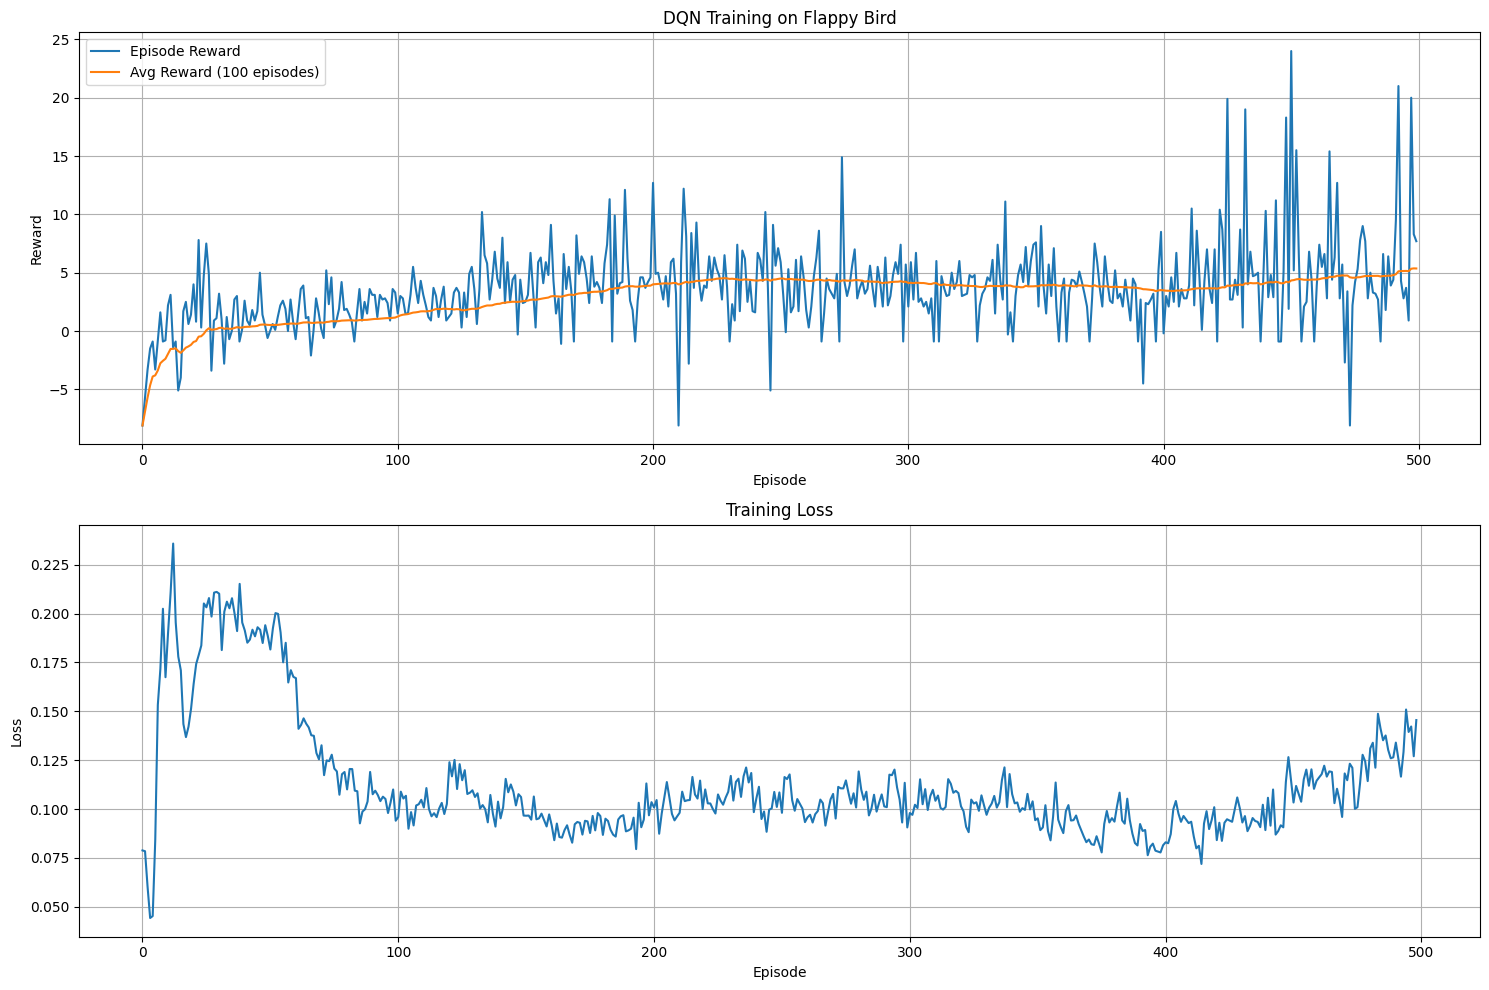

Test Episode: 1/5, Score: 24.200000000000127, Steps: 409
Test Episode: 2/5, Score: 9.599999999999966, Steps: 164
Test Episode: 3/5, Score: 12.699999999999942, Steps: 243
Test Episode: 4/5, Score: 9.299999999999942, Steps: 254
Test Episode: 5/5, Score: 13.49999999999993, Steps: 284


In [89]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import flappy_bird_gymnasium
import gymnasium as gym
from tqdm import tqdm

# 设置设备（GPU如果可用，否则CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        # DQN 超参数
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = 0.99  # 折扣因子
        self.learning_rate = 0.0001
        self.update_target_freq = 10  # 目标网络更新频率
        self.batch_size = 64
        
        # 创建主网络和目标网络
        self.model = DQN(state_size, action_size).to(device)
        self.target_model = DQN(state_size, action_size).to(device)
        self.update_target_network()  # 初始化目标网络
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        
        # 经验回放缓冲区
        self.memory = deque(maxlen=10000)
        
        # 训练计数器
        self.train_step = 0
    
    def update_target_network(self):
        """更新目标网络的权重为主网络的权重"""
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        """将经验存储到回放缓冲区"""
        self.memory.append((state, action, reward, next_state, done))
    
    def take_action(self, state, explore=True):
        """根据当前状态选择动作"""
        # 探索：随机选择动作
        if explore and np.random.random() < self.epsilon:
            return random.randrange(self.action_size)
        
        # 利用：选择Q值最高的动作
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action_values = self.model(state)
        return torch.argmax(action_values).item()
    
    def update(self):
        """从经验回放缓冲区中抽样并更新网络"""
        if len(self.memory) < self.batch_size:
            return
        
        # 从经验回放缓冲区中随机抽样
        minibatch = random.sample(self.memory, self.batch_size)
        
        # 准备批次数据
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        
        for state, action, reward, next_state, done in minibatch:
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        
        # 转换为张量
        states = torch.FloatTensor(np.array(states)).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        actions = torch.LongTensor(actions).to(device)
        dones = torch.FloatTensor(dones).to(device)
        
        # 计算当前Q值
        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # 计算目标Q值（使用目标网络）
        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        # 计算损失并更新网络
        self.optimizer.zero_grad()
        loss = self.criterion(current_q_values, target_q_values)
        loss.backward()
        # 梯度裁剪，防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        
        # 更新目标网络
        self.train_step += 1
        if self.train_step % self.update_target_freq == 0:
            self.update_target_network()
        
        # 衰减探索率
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return loss.item()

def preprocess_state(obs):
    """预处理观察值为神经网络的输入"""
    # Flappy Bird 的观察是一个包含多个值的数组
    # 我们将其转换为一维数组
    return np.array(obs, dtype=np.float32)

def train_dqn(episodes=1000, max_steps=1000, render_freq=100):
    """训练DQN智能体"""
    env = gym.make("FlappyBird-v0", render_mode=None)
    
    # 获取状态和动作空间大小
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    
    print(f"State size: {state_size}, Action size: {action_size}")
    
    # 创建智能体
    agent = Agent(state_size, action_size)
    
    # 记录训练历史
    rewards_history = []
    avg_rewards_history = []
    losses = []
    
    # 训练循环
    for episode in tqdm(range(episodes), desc="Training"):
        # 重置环境
        state, _ = env.reset()
        state = preprocess_state(state)
        
        total_reward = 0
        episode_loss = []
        
        # 创建渲染环境（如果需要）
        render_env = None
        if (episode + 1) % render_freq == 0:
            render_env = gym.make("FlappyBird-v0", render_mode="human")
            render_state, _ = render_env.reset()
        
        # 单个episode循环
        for step in range(max_steps):
            # 选择动作
            action = agent.take_action(state)
            
            # 执行动作
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = preprocess_state(next_state)
            done = terminated or truncated
            
            # 存储经验
            agent.remember(state, action, reward, next_state, done)
            
            # 更新网络
            if len(agent.memory) > agent.batch_size:
                loss = agent.update()
                if loss is not None:
                    episode_loss.append(loss)
            
            # 渲染（如果需要）
            if render_env is not None:
                render_action = agent.take_action(render_state, explore=False)
                render_state, _, render_terminated, render_truncated, _ = render_env.step(render_action)
                render_state = preprocess_state(render_state)
                if render_terminated or render_truncated:
                    render_env.close()
                    render_env = None
            
            # 更新状态和累积奖励
            state = next_state
            total_reward += reward
            
            # 如果游戏结束，退出循环
            if done:
                break
        
        # 记录本轮的奖励和损失
        rewards_history.append(total_reward)
        
        # 计算最近100轮的平均奖励
        avg_reward = np.mean(rewards_history[-100:])
        avg_rewards_history.append(avg_reward)
        
        # 如果有损失，计算平均损失
        if episode_loss:
            avg_loss = np.mean(episode_loss)
            losses.append(avg_loss)
        
        # 打印训练信息
        if (episode + 1) % 10 == 0:
            print(f"Episode: {episode+1}/{episodes}, Reward: {total_reward:.2f}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.4f}")
        
        # 保存模型
        if (episode + 1) % 100 == 0:
            torch.save(agent.model.state_dict(), f"flappy_bird_dqn_ep{episode+1}.pt")
    
    # 关闭环境
    env.close()
    if render_env is not None:
        render_env.close()
    
    # 保存最终模型
    torch.save(agent.model.state_dict(), "flappy_bird_dqn_final.pt")
    
    return agent, rewards_history, avg_rewards_history, losses

def test_agent(model_path, episodes=10):
    """测试训练好的智能体"""
    env = gym.make("FlappyBird-v0", render_mode="human")
    
    # 获取状态和动作空间大小
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    
    # 创建智能体并加载模型
    agent = Agent(state_size, action_size)
    agent.model.load_state_dict(torch.load(model_path))
    agent.epsilon = 0  # 测试时不探索
    
    for episode in range(episodes):
        state, _ = env.reset()
        state = preprocess_state(state)
        total_reward = 0
        done = False
        steps = 0
        
        while not done and steps < 3000:  # 限制最大步数
            action = agent.take_action(state, explore=False)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = preprocess_state(next_state)
            done = terminated or truncated
            
            state = next_state
            total_reward += reward
            steps += 1
        
        print(f"Test Episode: {episode+1}/{episodes}, Score: {total_reward}, Steps: {steps}")
    
    env.close()

def plot_training_results(rewards, avg_rewards, losses=None):
    """绘制训练结果"""
    plt.figure(figsize=(15, 10))
    
    # 绘制奖励
    plt.subplot(2, 1, 1)
    plt.plot(rewards, label='Episode Reward')
    plt.plot(avg_rewards, label='Avg Reward (100 episodes)')
    plt.title('DQN Training on Flappy Bird')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    
    # 绘制损失（如果有）
    if losses:
        plt.subplot(2, 1, 2)
        plt.plot(losses)
        plt.title('Training Loss')
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('flappy_bird_dqn_results.png')
    plt.show()

if __name__ == "__main__":
    # 训练智能体
    agent, rewards, avg_rewards, losses = train_dqn(episodes=500, max_steps=2000, render_freq=100)
    
    # 绘制训练结果
    plot_training_results(rewards, avg_rewards, losses)
    
    # 测试训练好的智能体
    test_agent("flappy_bird_dqn_final.pt", episodes=5) 